In [1]:
%matplotlib inline

In [3]:
!pip install siphon

     |████████████████████████████████| 71kB 836kB/s 



# Sounding Plotter


**This should be run as a script from the command line - not as a notebook.**

Download and plot the most recent sounding data for a specified site.

Provides a simple command line interface to specify a site. Using the current
UTC time, the script calculates what the most recent sounding should be and requests
it from the Wyoming archive using Siphon.


Do the needed imports


In [4]:
import posixpath

import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import add_metpy_logo, add_timestamp, SkewT
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

This class encapsulates the code needed to upload an image to Google Drive



In [5]:
class DriveUploader:
    def __init__(self, credsfile='mycreds.txt'):
        from pydrive.drive import GoogleDrive
        self.gdrive = GoogleDrive(self._get_auth(credsfile))

    def _get_auth(self, credsfile):
        from pydrive.auth import GoogleAuth
        gauth = GoogleAuth()

        # Try to load saved client credentials
        gauth.LoadCredentialsFile(credsfile)
        if gauth.credentials is None:
            # Authenticate if they're not there
            gauth.LocalWebserverAuth()
        elif gauth.access_token_expired:
            # Refresh them if expired
            gauth.Refresh()
        else:
            # Initialize the saved creds
            gauth.Authorize()
        # Save the current credentials to a file
        gauth.SaveCredentialsFile(credsfile)
        return gauth

    def _get_first_file_id(self, title, parent, **kwargs):
        query = "title='{}' and '{}' in parents".format(title, parent)
        for k, v in kwargs.items():
            query += " and {}='{}'".format(k, v)
        res = next(self.gdrive.ListFile({'q': query}))
        if res:
            return res[0]['id']
        return None

    def get_folder(self, path):
        parent = 'root'
        for part in path.split('/'):
            if not part:
                continue
            parent = self._get_first_file_id(part, parent,
                                             mimeType='application/vnd.google-apps.folder')
        return parent

    def create_or_get_file(self, path):
        pathname, filename = posixpath.split(path)
        folder = self.get_folder(pathname)
        create_file_args = {'parents': [{'kind': 'drive#fileLink', 'id': folder}]}

        file_id = self._get_first_file_id(filename, folder)
        if file_id is not None:
            create_file_args['id'] = file_id
        return self.gdrive.CreateFile(create_file_args)

    def upload_to(self, local_path, remote_path):
        f = self.create_or_get_file(remote_path)
        f.SetContentFile(local_path)
        f['title'] = posixpath.basename(remote_path)
        f.Upload()

This function takes care of actually generating a skewT from the `DataFrame`



In [6]:
def plot_skewt(df):
    # We will pull the data out of the example dataset into individual variables
    # and assign units.
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    wind_speed = df['speed'].values * units.knots
    wind_dir = df['direction'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)

    # Create a new figure. The dimensions here give a good aspect ratio.
    fig = plt.figure(figsize=(9, 9))
    add_metpy_logo(fig, 115, 100)
    skew = SkewT(fig, rotation=45)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p, u, v)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)

    # Calculate LCL height and plot as black dot
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    skew.plot(p, prof, 'k', linewidth=2)

    # An example of a slanted line at constant T -- in this case the 0
    # isotherm
    skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    return skew


def make_name(site, time):
    return '{site}_{dt:%Y%m%d_%H%M}.png'.format(site=site, dt=time)

This is where the command line script will actually enter, and handles parsing
command line arguments and driving everything else.



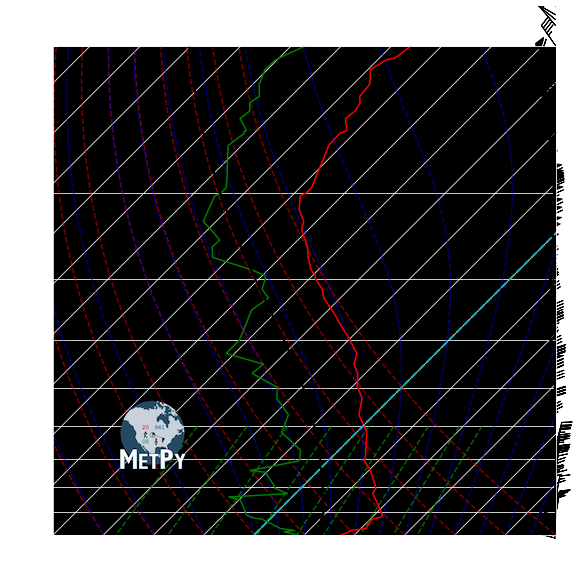

In [8]:
if __name__ == '__main__':
    import argparse
    from datetime import datetime, timedelta
    import tempfile

    # Set up argument parsing for the script. Provides one argument for the site, and another
    # that controls whether the plot should be shown or saved as an image.
    parser = argparse.ArgumentParser(description='Download sounding data and plot.')
    parser.add_argument('-s', '--site', help='Site to obtain data for', type=str,
                        default='OAK')
    parser.add_argument('--show', help='Whether to show the plot rather than save to disk',
                        action='store_true')
    parser.add_argument('-d', '--date', help='Date and time to request data for in YYYYMMDDHH.'
                        ' Defaults to most recent 00/12 hour.', type=str)
    parser.add_argument('-g', '--gdrive', help='Google Drive upload path', type=str)
    parser.add_argument('-f', '--filename', help='Image filename', type=str)
    args = parser.parse_args()

    if args.date:
        request_time = datetime.strptime(args.date, '%Y%m%d%H')
    else:
        # Figure out the most recent sounding, 00 or 12. Subtracting two hours
        # helps ensure that we choose a time with data available.
        now = datetime.utcnow() - timedelta(hours=2)
        request_time = now.replace(hour=(now.hour // 12) * 12, minute=0, second=0)

    # Request the data and plot
    df = WyomingUpperAir.request_data(request_time, args.site)
    skewt = plot_skewt(df)

    # Add the timestamp for the data to the plot
    add_timestamp(skewt.ax, request_time, y=1.02, x=0, ha='left', fontsize='large')
    skewt.ax.set_title(args.site)

    if args.show:
        plt.show()
    else:
        fname = args.filename if args.filename else make_name(args.site, request_time)
        if args.gdrive:
            uploader = DriveUploader()
            with tempfile.NamedTemporaryFile(suffix='.png') as f:
                skewt.ax.figure.savefig(f.name)
                uploader.upload_to(f.name, posixpath.join(args.gdrive, fname))
        else:
            skewt.ax.figure.savefig(make_name(args.site, request_time))

In [ ]:
DNR